# Day2 課題

## 概要
KaggleのKickstarterのデータを用いて、機械学習のモデルを作成する。

Day1の内容から更に以下の内容についての実装および検証を行う。

- 交差検証、ホールドアウト
- 正規化、標準化、無相関化、白色化
- ハイパーパラメータ探索

## 内容
以下の内容で検証を行う。

1. Day1の内容の見直し
2. 交差検証、ホールドアウト法の実施
3. データの正規化、標準化、無相関化、白色化についての考察
4. ハイパーパラメータ探索



## Day1の内容の見直し
Day1の課題で指摘のあった以下の内容について、見直しを行う。

- ドル換算の目標金額のlog換算
- 国による取捨選択
- プロジェクト名

### ライブラリ、データの読み込み、初期処理

In [211]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
import math

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数


from sklearn.preprocessing import MinMaxScaler # 正規化関数
from sklearn.preprocessing import StandardScaler # 標準化関数

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

In [212]:
# グラフ表示用メソッド定義
def plot_graph(df, item_name):
    fig,ax = plt.subplots(1,2, figsize=(20,6))

    # 項目のグラフ表示
    sns_ax = ax[0]
    sns_item=sns.countplot(df[item_name],order=np.sort(df[item_name].unique()), ax=sns_ax)
    sns_item.set_xticklabels(sns_item.get_xticklabels(), rotation=90, ha="right")  # 90度回転
    
    #　項目の成否の割合
    cross_ax = ax[1]
    cross_item = pd.crosstab(df[item_name],df['state'],normalize='index')
    cross_item.plot.bar(stacked=True, ax=cross_ax)

    plt.tight_layout()
    plt.show()

In [213]:
# 関数定義
# sucessfulとfailed以外を削除する関数
def remove_date_about_state(df_ks):
    df_ks_result = df_ks[(df_ks["state"] == "successful")|(df_ks["state"] == "failed")].copy()
    return df_ks_result

# 期間、開始日時の月、終了日時の月を項目として加える関数
def add_item_days_month(df_ks_result):
    # 期間算出
    #df_ks_result["days"] = df_ks_result.apply(lambda x: (dt.strptime(x['deadline'], '%Y-%m-%d') - dt.strptime(x['launched'], '%Y-%m-%d %H:%M:%S')).days , axis=1)
    df_ks_result.loc[df_ks_result["deadline"].isnull() == False, "days"] = df_ks_result.apply(lambda x: (dt.strptime(x["deadline"], '%Y-%m-%d') - dt.strptime(x["launched"], '%Y-%m-%d %H:%M:%S')).days , axis=1)

    # 月算出
    launched_month_func = lambda launched : dt.strptime(launched, '%Y-%m-%d %H:%M:%S').month
    #df_ks_result["launched_month"] = df_ks_result['launched'].map( launched_month_func)
    df_ks_result.loc[df_ks_result["launched"].isnull()==False,"launched_month"] = df_ks_result["launched"].map( launched_month_func)

    deadline_month_func = lambda deadline : dt.strptime(deadline, '%Y-%m-%d').month
    #df_ks_result["deadline_month"] = df_ks_result['deadline'].map(deadline_month_func)
    df_ks_result.loc[df_ks_result["deadline"].isnull()==False,"deadline_month"] = df_ks_result["deadline"].map( deadline_month_func)

# successfulをTrueとし、それ以外をFalseに設定する関数
def change_data_about_state(df_ks):
    df_ks.loc[df_ks['state'] == 'successful', "state_bool"] = True
    df_ks.loc[df_ks['state'] != 'successful',"state_bool"] = False


In [214]:
# データ読み込み
df_ks = pd.read_csv("../1_data/ks-projects-201801.csv")

In [215]:
# 削除する列の定義
drop_list = ("state","goal","ID","name","currency","deadline","launched","pledged","backers","usd pledged","usd_pledged_real")

# 使用する項目のリスト
item_list = ("state_bool","usd_goal_real","days","lauched_month","deadline_month","country","category","main_category")

# ダミー変数化する項目
dummy_items = ['launched_month','deadline_month','country','category','main_category']



In [216]:
# "state"の"successful"と"failed"以外を削除
df_ks_data = remove_date_about_state(df_ks)

# successfulとfailedをTrue,Falseにする。
change_data_about_state(df_ks_data)

# 期間、開始月、終了月の算出
add_item_days_month(df_ks_data)


# 結果などの予測に使えないデータを予め削除
for item in drop_list:
        df_ks_data = df_ks_data.drop(item, axis=1)
        

In [217]:
# データの確認
#display(df_ks_data_all.head())

display(df_ks_data.head())

,category,main_category,country,usd_goal_real,state_bool,days,launched_month,deadline_month
0,Poetry,Publishing,GB,1533.95,False,58,8,10
1,Narrative Film,Film & Video,US,30000.00,False,59,9,11
2,Narrative Film,Film & Video,US,45000.00,False,44,1,2
3,Music,Music,US,5000.00,False,29,3,4
5,Restaurants,Food,US,50000.00,True,34,2,4


### ドル換算の目標金額のlog換算
ドル換算の目標金額については各プロジェクトの設定の違いが大きい。

よって、log関数によって値の単位を変更し、それによるモデルの作成を行う。

In [218]:
# ドル換算の目標金額をlog10で変換し、格納し、元の目的変数を削除
def trans_log_usd_goal_real(df_arg):
    log_usd_goal_real_func = lambda x : math.log10(x)
    df_arg.loc[df_arg["usd_goal_real"].isnull() == False, "log_usd_goal_real"]  \
        = df_arg["usd_goal_real"].map( log_usd_goal_real_func)
    df_arg_ret = df_arg.drop("usd_goal_real",axis=1)
    return df_arg_ret

df_ks_data_log = trans_log_usd_goal_real(df_ks_data)

In [219]:
display(df_ks_data_log.head())

,category,main_category,country,state_bool,days,launched_month,deadline_month,log_usd_goal_real
0,Poetry,Publishing,GB,False,58,8,10,3.185811
1,Narrative Film,Film & Video,US,False,59,9,11,4.477121
2,Narrative Film,Film & Video,US,False,44,1,2,4.653213
3,Music,Music,US,False,29,3,4,3.698970
5,Restaurants,Food,US,True,34,2,4,4.698970


平均:3.727
中央値:3.699
最大値:8.221
最小値:-2.000
分散:0.528
標準偏差:0.727


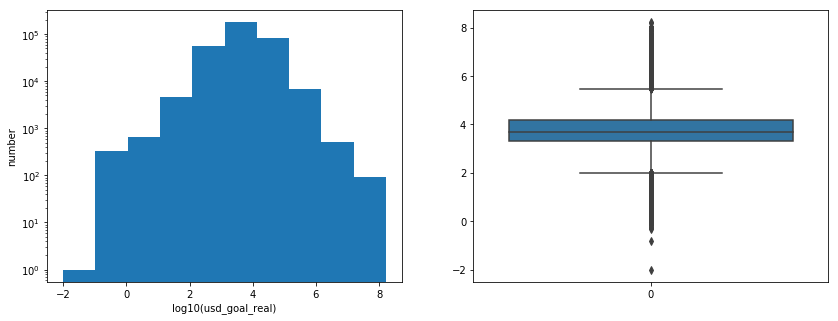

In [220]:
# グラフの表示
log_usd_goal_real_list = df_ks_data_log['log_usd_goal_real']

print("平均:{:.3f}".format(log_usd_goal_real_list.mean()))
print("中央値:{:.3f}".format(log_usd_goal_real_list.median()))
print("最大値:{:.3f}".format(log_usd_goal_real_list.max()))
print("最小値:{:.3f}".format(log_usd_goal_real_list.min()))
print("分散:{:.3f}".format(log_usd_goal_real_list.var()))
print("標準偏差:{:.3f}".format(log_usd_goal_real_list.std()))

# 縦軸は対数で表す。
fig,ax = plt.subplots(1,2,figsize = (14,5))
ax[0].hist(log_usd_goal_real_list,log=True)
ax[0].set_xlabel('log10(usd_goal_real)')
ax[0].set_ylabel('number')

# 箱髭図
sns.boxplot(data=log_usd_goal_real_list,ax=ax[1])
#ax[1].set(ylim=(0,50000)) # 上限を制限
plt.show()

In [221]:
# モデル作成
def make_model(X, y):
    clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
    clf.fit(X, y)
    return clf    


# モデル作成(state_boolを目的変数、それいがいを説明変数に自動で分ける)
def make_model_df(df_arg):
    y = df_arg["state_bool"].values
    X = df_arg.drop('state_bool', axis=1)
    clf = make_model(X, y)
    return clf,X,y


# 予測
def run_model(clf,X):
    # ラベルを予測
    y_est = clf.predict(X)
    return y_est

# 結果の表示
def print_result(y, y_est):
    # 対数尤度を表示
    print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

    # 正答率を計算
    accuracy =  accuracy_score(y, y_est)
    print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

    # Precision, Recall, F1-scoreを計算
    precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

    # state_book が Trueに関するPrecision, Recall, F1-scoreを表示
    # precision[1],recall[1],f1_score[1]で取得しているため、修正の可能性あり。（0で取得かどうか不明）
    print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
    print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
    print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))
    
    
# 予測値と正解のクロス集計
def make_cross(y,y_est):
    conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
    return conf_mat


# モデルから予測と予測結果の表示
def run_model_and_print_result(X,y,clf):
    # テスト用データで予測
    y_est = run_model(clf, X)

    # テスト用データと予測結果の内容を表示
    print_result(y, y_est)
    
    # 予測値と正解のクロス集計
    conf_mat = make_cross(y, y_est)
    print(conf_mat)

In [222]:
# ダミー変数化
df_ks_data_log_all = pd.get_dummies(df_ks_data_log,  columns=dummy_items ,drop_first = True)

In [223]:
display(df_ks_data_log_all.head())

,state_bool,days,log_usd_goal_real,launched_month_2,launched_month_3,launched_month_4,launched_month_5,launched_month_6,launched_month_7,launched_month_8,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,False,58,3.185811,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,False,59,4.477121,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,False,44,4.653213,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,False,29,3.698970,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,True,34,4.698970,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [224]:
# モデル作成
clf, X, y = make_model_df(df_ks_data_log_all)
clf

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [225]:
# 予測と表示
run_model_and_print_result(X,y,clf)

対数尤度 = -13.603
正答率（Accuracy） = 60.615%
適合率（Precision） = 50.771%
再現率（Recall） = 81.750%
F1値（F1-score） = 62.639%
         予測 = 失敗  予測 = 成功
正解 = 失敗    91535   106184
正解 = 成功    24447   109509


（考察）　全般的にlog関数を用いない場合に比べて、5%ほど上昇した。

### 国による取捨選択

国ごとのプロジェクト数を算出し比較する。

In [226]:
# 国毎のプロジェクト数を算出する。
df_ks_data["country"].value_counts()

US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64

（考察）LU,JPが少ないので、いったん外して、モデル作成、検証を行ってみる。

In [227]:
df_ks_data_country = df_ks_data.copy()
df_ks_data_country.drop(df_ks_data_country.loc[(df_ks_data_country["country"]=="JP")|(df_ks_data_country["country"]=="LU")].index, inplace=True)

In [228]:
df_ks_data_country["country"].value_counts()

US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
Name: country, dtype: int64

In [229]:
# ダミー変数化
df_ks_data_country_all = pd.get_dummies(df_ks_data_country,  columns=dummy_items)

In [230]:
# モデル作成
clf, X, y = make_model_df(df_ks_data_country_all)
clf

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [231]:
# 予測と表示
run_model_and_print_result(X,y,clf)

対数尤度 = -18.550
正答率（Accuracy） = 46.292%
適合率（Precision） = 42.708%
再現率（Recall） = 96.565%
F1値（F1-score） = 59.224%
         予測 = 失敗  予測 = 成功
正解 = 失敗    24173   173492
正解 = 成功     4600   129330


（考察）　明確に良くなったとは言えない。

### プロジェクト名の検討
プロジェクト名について検討する。

以下が検討対象として考える。

- 長さ
- 文字数


In [232]:
def trans_name(df_arg):
    # name でnan値が入っているので、空白で置換え
    df_arg['name'] = df_arg['name'].fillna(" ")
    # 名前の長さの算出
    df_arg.loc[:,"name_len"] = df_arg["name"].map(lambda name: len(name))
    # 名前の頭文字の算出
    df_arg.loc[df_arg['name_len'] >= 1, "name_init"] = df_arg["name"].map(lambda name: name[0:1])
    return df_arg

In [233]:
# "state"の"successful"と"failed"以外を削除
df_ks_data_name = remove_date_about_state(df_ks)

# successfulとfailedをTrue,Falseにする。
change_data_about_state(df_ks_data_name)

# 期間、開始月、終了月の算出
add_item_days_month(df_ks_data_name)

# 名前部分の長さと頭文字の算出
df_ks_data_name = trans_name(df_ks_data_name)

#### 文字数
プロジェクト名の文字数について調べる。

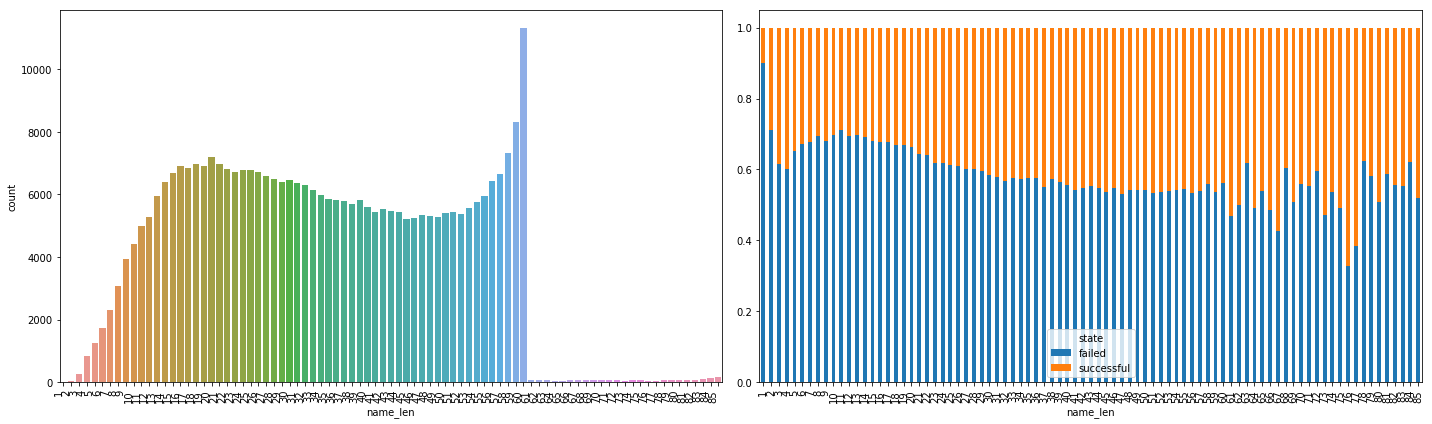

In [234]:
plot_graph(df_ks_data_name,"name_len")

#### 頭文字

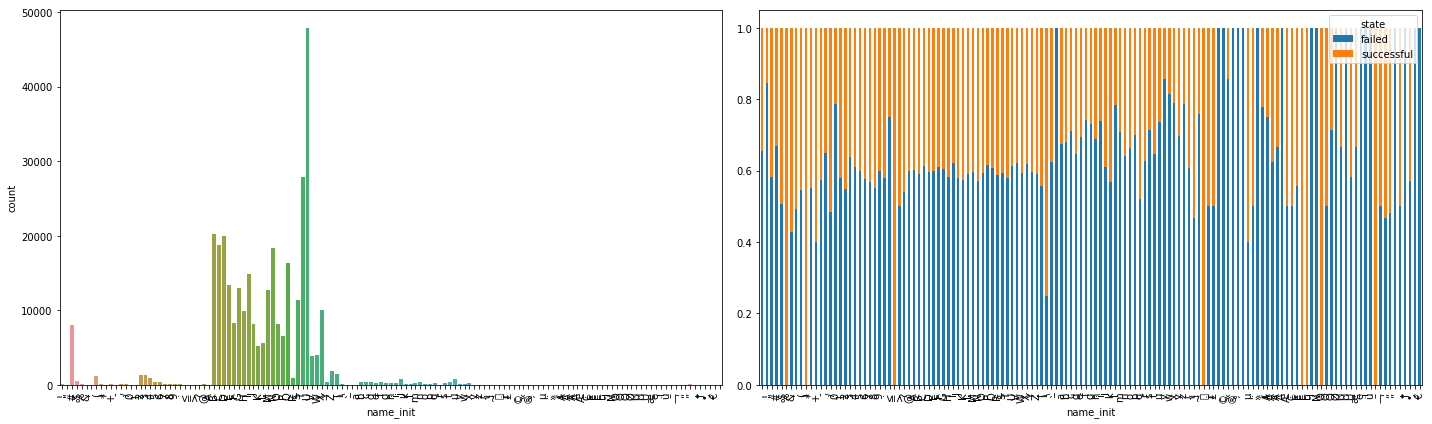

In [235]:
plot_graph(df_ks_data_name,"name_init")

#### 検証

In [236]:
# 削除する列の定義
drop_list = ("state","goal","ID","name","currency","deadline","launched","pledged","backers","usd pledged","usd_pledged_real")

# 使用する項目のリスト
item_list = ("state_bool","name_len","name_init","usd_goal_real","days","lauched_month","deadline_month","country","category","main_category")

# ダミー変数化する項目
dummy_items = ["name_init",'launched_month','deadline_month','country','category','main_category']


# 結果などの予測に使えないデータを予め削除
for item in drop_list:
        df_ks_data_name = df_ks_data_name.drop(item, axis=1)



# ダミー変数化
df_ks_data_name = pd.get_dummies(df_ks_data_name,  columns=dummy_items ,drop_first = True)

df_ks_data_name.head()

,usd_goal_real,state_bool,days,name_len,name_init_!,"name_init_""",name_init_#,name_init_$,name_init_%,name_init_&,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,1533.95,False,58,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,30000.00,False,59,45,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,45000.00,False,44,14,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,5000.00,False,29,49,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,50000.00,True,34,20,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [237]:
# モデル作成
clf, X, y = make_model_df(df_ks_data_name)
clf

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [238]:
# 予測と表示
run_model_and_print_result(X,y,clf)

対数尤度 = -15.142
正答率（Accuracy） = 56.160%
適合率（Precision） = 47.366%
再現率（Recall） = 76.851%
F1値（F1-score） = 58.609%
         予測 = 失敗  予測 = 成功
正解 = 失敗    83322   114397
正解 = 成功    31010   102946


###  検討結果
目的変数（ドル換算の目標金額)のlog換算は効果があった。

プロジェクト名に関する長さと頭文字についても一応入れてみる。

## 交差検証、ホールドアウト法の実施
交差検証、ホールドアウト法を実施する。

以下の手順で実施してみる。

1. 対象データの4/5を訓練データ、1/5をテストデータとしてランダムに抽出し、分けておく。
2. 訓練データを更に1/5ずつに分割して、それぞれごとのモデルを作成し、交差検証を行う。
3. 上記で作成したモデルのうち、最も成績の良いものを使用して、最初に分けておいたテストデータを用いてホールドアウトによる検証を行う。

### データの分割
対象データの4/5を訓練データ、1/5をテストデータとしてランダムに抽出しする。

In [239]:
# 対象データの作成
# データ読み込み
df_ks = pd.read_csv("../1_data/ks-projects-201801.csv")

# 削除する列の定義
drop_list = ("state","goal","ID","name","currency","deadline","launched","pledged","backers","usd pledged","usd_pledged_real")

# 使用する項目のリスト
item_list = ("state_bool","name_len","name_init","log_usd_goal_real","days","lauched_month","deadline_month","country","category","main_category")

# ダミー変数化する項目
dummy_items = ["name_init",'launched_month','deadline_month','country','category','main_category']

# "state"の"successful"と"failed"以外を削除
df_ks_data = remove_date_about_state(df_ks)

# usd_goal_realのlog換算
df_ks_data = trans_log_usd_goal_real(df_ks_data)

# successfulとfailedをTrue,Falseにする。
change_data_about_state(df_ks_data)

# 期間、開始月、終了月の算出
add_item_days_month(df_ks_data)

# プロジェクト名の文字数と頭文字の算出
df_ks_data = trans_name(df_ks_data)

# 結果などの予測に使えないデータを予め削除
for item in drop_list:
        df_ks_data = df_ks_data.drop(item, axis=1)
        
# ダミー変数化
df_ks_data = pd.get_dummies(df_ks_data,  columns=dummy_items ,drop_first = True)

In [240]:
# 対象データのうち1/5をテストデータとする。
y = df_ks_data["state_bool"].values
X = df_ks_data.drop('state_bool', axis=1)

test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train_hold, X_test_hold, y_train_hold, y_test_hold = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

### 交差検証
訓練データを1/5ずつに分割し、1/5の部分をテストデータ、残りを訓練データとして、交差検証を行う。
そのうち、最も成績の良いモデルを採用する。

In [241]:
n_split = 5 # グループ数を設定（今回は5分割）


def cross_valid(X_train, y_train, n_split):
    # モデル配列定義
    clf_list = []
    for i,[train_idx, test_idx] in enumerate(KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X_train, y_train)):
        X_train_tmp, y_train_tmp = X_train.iloc[train_idx], y_train[train_idx] #学習用データ
        X_test_tmp, y_test_tmp = X_train.iloc[test_idx], y_train[test_idx]     #テスト用データ
        # 学習用データでモデル作成
        clf_list.append(make_model(X_train_tmp,y_train_tmp))
        clf = clf_list[i]
        
        # 各モデルの予測と結果表示
        print('モデル{0}'.format(i))
        run_model_and_print_result(X_test_tmp,y_test_tmp,clf) 
        print("\n")
    return clf_list

clf_list = cross_valid(X_train_hold.copy(), y_train_hold.copy(), 5)

モデル0
対数尤度 = -12.543
正答率（Accuracy） = 63.684%
適合率（Precision） = 53.593%
再現率（Recall） = 77.746%
F1値（F1-score） = 63.449%
         予測 = 失敗  予測 = 成功
正解 = 失敗    17069    14484
正解 = 成功     4788    16727


モデル1
対数尤度 = -11.375
正答率（Accuracy） = 67.065%
適合率（Precision） = 60.737%
再現率（Recall） = 54.272%
F1値（F1-score） = 57.323%
         予測 = 失敗  予測 = 成功
正解 = 失敗    23852     7588
正解 = 成功     9890    11738


モデル2
対数尤度 = -11.928
正答率（Accuracy） = 65.465%
適合率（Precision） = 68.586%
再現率（Recall） = 26.775%
F1値（F1-score） = 38.514%
         予測 = 失敗  予測 = 成功
正解 = 失敗    29001     2629
正解 = 成功    15698     5740


モデル3
対数尤度 = -13.003
正答率（Accuracy） = 62.354%
適合率（Precision） = 52.230%
再現率（Recall） = 79.946%
F1値（F1-score） = 63.182%
         予測 = 失敗  予測 = 成功
正解 = 失敗    15948    15678
正解 = 成功     4300    17142


モデル4
対数尤度 = -11.421
正答率（Accuracy） = 66.933%
適合率（Precision） = 60.560%
再現率（Recall） = 50.797%
F1値（F1-score） = 55.251%
         予測 = 失敗  予測 = 成功
正解 = 失敗    24687     7055
正解 = 成功    10493    10833




（考察）　とりあえず、モデル0が平均的に良さそうなので、モデル0を使用する。

### ホールドアウト法
交差検証で採用したモデルを使用し、予め最初に分けておいたテストデータを用いて、ホールドアウト法による検証を行う。
すでにモデルは作成済なので、テストデータで予想して比較検討する。

In [242]:
# 使用するモデル
model_no = 0

clf = clf_list[model_no]    
run_model_and_print_result(X_test_hold, y_test_hold, clf)

対数尤度 = -12.755
正答率（Accuracy） = 63.072%
適合率（Precision） = 52.717%
再現率（Recall） = 76.980%
F1値（F1-score） = 62.579%
         予測 = 失敗  予測 = 成功
正解 = 失敗    21357    18371
正解 = 成功     6125    20482


（考察）　選択したモデルとほぼ同じ値がでた。

## 正規化、標準化
量的変数の正規化、標準化などを行う。

量的変数は現在以下のものがある。
- 期間
- ドル換算の目標金額のlog換算

### 正規化
正規化してみる

In [243]:
mms = MinMaxScaler()

# 期間
days_ary = df_ks_data["days"].to_numpy().reshape(-1,1)
days_mms = mms.fit_transform(days_ary)
print("期間の正規化")
print(days_mms)
print("\n")

# ドル換算の目標金額のlog換算
log_usd_goal_real_ary = df_ks_data["log_usd_goal_real"].to_numpy().reshape(-1,1)
log_usd_goal_real_mms = mms.fit_transform(log_usd_goal_real_ary)
print("ドル換算の目標金額のログ換算の正規化")
print(log_usd_goal_real_mms)
print("\n")

# プロジェクト名の文字数
name_len_ary = df_ks_data["name_len"].to_numpy().reshape(-1,1)
name_len_mms = mms.fit_transform(name_len_ary)
print("プロジェクト名の文字数の正規化")
print(name_len_mms)


期間の正規化
[[0.63736264]
 [0.64835165]
 [0.48351648]
 ...
 [0.49450549]
 [0.32967033]
 [0.2967033 ]]


ドル換算の目標金額のログ換算の正規化
[[0.50736567]
 [0.63370394]
 [0.65093223]
 ...
 [0.60425198]
 [0.60425198]
 [0.51863837]]


プロジェクト名の文字数の正規化
[[0.35714286]
 [0.52380952]
 [0.1547619 ]
 ...
 [0.83333333]
 [0.27380952]
 [0.38095238]]


C:\Users\fumit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\fumit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### 標準化

In [244]:
stdsc = StandardScaler()

# 期間
days_ary = df_ks_data["days"].to_numpy().reshape(-1,1)
days_stdsc = stdsc.fit_transform(days_ary)
print("期間の標準化")
print(days_stdsc)
print("\n")

# ドル換算の目標金額のlog換算
log_usd_goal_real_ary = df_ks_data["log_usd_goal_real"].to_numpy().reshape(-1,1)
log_usd_goal_real_stdsc = stdsc.fit_transform(log_usd_goal_real_ary)
print("ドル換算の目標金額のログ換算の標準化")
print(log_usd_goal_real_stdsc)
print("\n")

# プロジェクト名の文字数
name_len_ary = df_ks_data["name_len"].to_numpy().reshape(-1,1)
name_len_stdsc = stdsc.fit_transform(name_len_ary)
print("プロジェクト名の文字数の標準化")
print(name_len_stdsc)


期間の標準化
[[ 1.96999036]
 [ 2.04864808]
 [ 0.86878226]
 ...
 [ 0.94743998]
 [-0.23242583]
 [-0.46839899]]


ドル換算の目標金額のログ換算の標準化
[[-0.74417332]
 [ 1.03275053]
 [ 1.27506318]
 ...
 [ 0.61851432]
 [ 0.61851432]
 [-0.58562502]]


プロジェクト名の文字数の標準化
[[-0.20173484]
 [ 0.6753637 ]
 [-1.26678306]
 ...
 [ 2.30426099]
 [-0.64028411]
 [-0.07643504]]


C:\Users\fumit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\fumit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\fumit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\fumit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### 正規化、標準化のグラフ表示

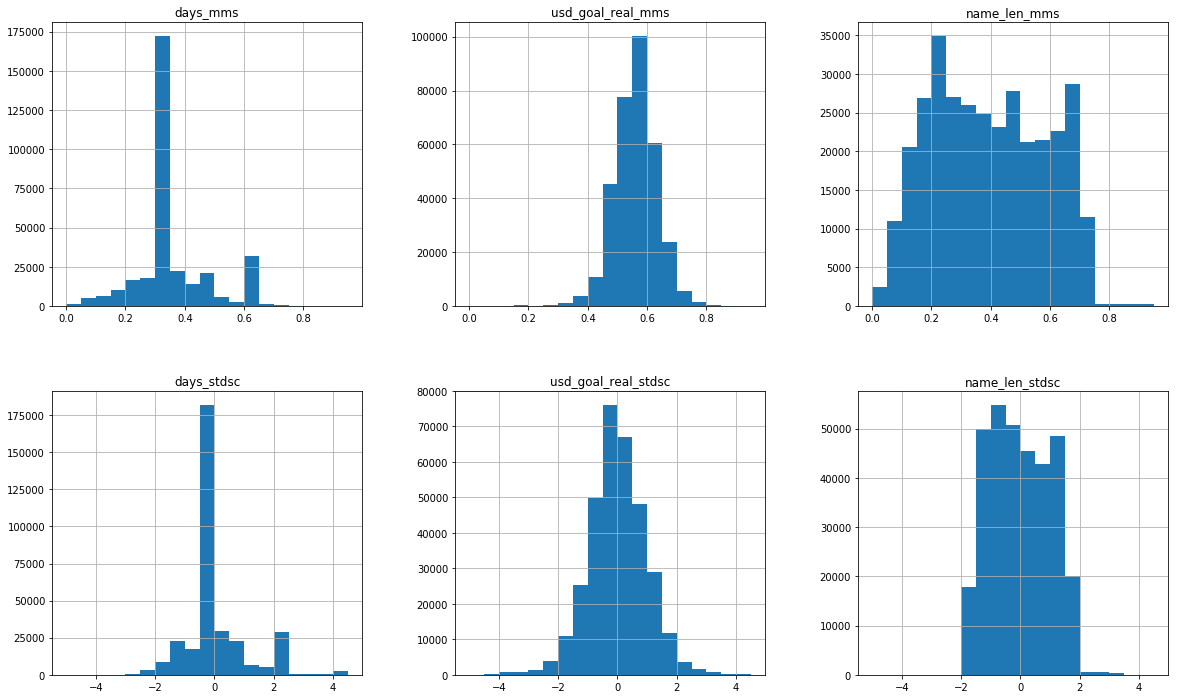

In [245]:
df_days_mms = pd.DataFrame(data=days_mms, columns=['days_mms'])
df_log_usd_goal_real_mms = pd.DataFrame(data=log_usd_goal_real_mms, columns=['usd_goal_real_mms'])
df_name_len_mms = pd.DataFrame(data=name_len_mms, columns=['name_len_mms'])

df_days_stdsc = pd.DataFrame(data=days_stdsc, columns=['days_stdsc'])
df_log_usd_goal_real_stdsc = pd.DataFrame(data=log_usd_goal_real_stdsc, columns=['usd_goal_real_stdsc'])
df_name_len_stdsc = pd.DataFrame(data=name_len_stdsc, columns=['name_len_stdsc'])


fig,ax = plt.subplots(2,3, figsize=(20,12))
df_days_mms.hist(bins=np.arange(0,1,.05),ax=ax[0,0]) # 期間の正規化グラフ
df_log_usd_goal_real_mms.hist(bins=np.arange(0,1,.05),ax=ax[0,1]) # 目標金額ログ換算の正規化グラフ
df_name_len_mms.hist(bins=np.arange(0,1,.05),ax=ax[0,2]) # 期間の正規化グラフ

df_days_stdsc.hist(bins=np.arange(-5,5,0.5),ax=ax[1,0]) # 期間の標準化
df_log_usd_goal_real_stdsc.hist(bins=np.arange(-5,5,0.5),ax=ax[1,1]) # 目標金額ログ換算の標準化グラフ
df_name_len_stdsc.hist(bins=np.arange(-5,5,0.5),ax=ax[1,2]) # 期間の標準化

plt.show()

（考察）　標準化の方が中央によっているので、良さそう。

### 標準化でのモデルの検証

量的変数を標準化し、モデルを作成して検証してみる。

In [246]:
# 対象データのうち1/5をテストデータとする。
y = df_ks_data["state_bool"].values
X = df_ks_data.drop('state_bool', axis=1)

test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train_hold, X_test_hold, y_train_hold, y_test_hold = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

In [247]:
# 対象の項目を標準化し、標準化した項目を増やし、元の対象の項目を落とす。
def trans_stdsc(df_arg, item, stdsc_item,stdsc,fit):
    # fitする (train用)
    if fit == True:
        df_arg.loc[:,stdsc_item]  = stdsc.fit_transform(df_arg[item].to_numpy().reshape(-1,1))
    # fitしない(test用)
    else:
        df_arg.loc[:,stdsc_item]  = stdsc.transform(df_arg[item].to_numpy().reshape(-1,1))        
    df_arg = df_arg.drop(item, axis=1)
    return df_arg



# 量的変数を標準化し,データを作成する。
stdsc_days = StandardScaler()
stdsc_log_usd_goal_real = StandardScaler()
stdsc_name_len = StandardScaler()

# 期間の標準化を追加
X_train_hold= trans_stdsc(X_train_hold,"days","days_stdsc",stdsc_days,True)

# ドル換算の目標金額のlog換算の標準化を追加
X_train_hold = trans_stdsc(X_train_hold,"log_usd_goal_real","log_usd_goal_real_stdsc",stdsc_log_usd_goal_real,True)

# プロジェクト名の文字数の標準化を追加
X_train_hold= trans_stdsc(X_train_hold,"name_len","name_len_stdsc",stdsc_name_len,True)



C:\Users\fumit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\fumit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\fumit\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\fumit\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [248]:
X_train_hold.head()

,name_init_!,"name_init_""",name_init_#,name_init_$,name_init_%,name_init_&,name_init_',name_init_(,name_init_),name_init_*,...,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,days_stdsc,log_usd_goal_real_stdsc,name_len_stdsc
289768,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.310477,-0.169959,1.429303
123513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1.097825,-1.540128,-1.768677
176735,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0.870545,0.926021,0.300604
21382,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.398136,0.072530,1.492008
54307,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,-1.334030,-1.171085,1.053070


In [249]:
# 交差検証
n_split = 5 # グループ数を設定（今回は5分割）
clf_list = cross_valid(X_train_hold.copy(), y_train_hold.copy(), 5)

モデル0
対数尤度 = -11.275
正答率（Accuracy） = 67.355%
適合率（Precision） = 61.664%
再現率（Recall） = 51.490%
F1値（F1-score） = 56.120%
         予測 = 失敗  予測 = 成功
正解 = 失敗    24666     6887
正解 = 成功    10437    11078


モデル1
対数尤度 = -11.211
正答率（Accuracy） = 67.540%
適合率（Precision） = 61.795%
再現率（Recall） = 53.315%
F1値（F1-score） = 57.243%
         予測 = 失敗  予測 = 成功
正解 = 失敗    24311     7129
正解 = 成功    10097    11531


モデル2
対数尤度 = -11.147
正答率（Accuracy） = 67.726%
適合率（Precision） = 62.569%
再現率（Recall） = 50.051%
F1値（F1-score） = 55.615%
         予測 = 失敗  予測 = 成功
正解 = 失敗    25211     6419
正解 = 成功    10708    10730


モデル3
対数尤度 = -11.217
正答率（Accuracy） = 67.525%
適合率（Precision） = 61.986%
再現率（Recall） = 50.746%
F1値（F1-score） = 55.806%
         予測 = 失敗  予測 = 成功
正解 = 失敗    24953     6673
正解 = 成功    10561    10881


モデル4
対数尤度 = -11.254
正答率（Accuracy） = 67.417%
適合率（Precision） = 62.093%
再現率（Recall） = 48.575%
F1値（F1-score） = 54.508%
         予測 = 失敗  予測 = 成功
正解 = 失敗    25418     6324
正解 = 成功    10967    10359




（考察）　ホールドアウトと交差検証を組み合わせる場合、交差検証部分では全部fitで良いのかどうか？
交差検証部分は全部訓練と考えるならfit_transformだし、交差検証部分の中身を分割ごとに訓練とテストだと考えるなら、fit_transformとtransformを使い分けるべきだが、どっちか？
（とりあえずは上記の交差検証部分は、fit_transformで統一）

In [250]:
#　モデル1を採用し、ホールドアウト法

# 期間の標準化を追加
X_test_hold= trans_stdsc(X_test_hold,"days","days_stdsc",stdsc_days,False)


# ドル換算の目標金額のlog換算の標準化を追加
X_test_hold = trans_stdsc(X_test_hold,"log_usd_goal_real","log_usd_goal_real_stdsc",stdsc_log_usd_goal_real,False)

# 期間の標準化を追加
X_test_hold= trans_stdsc(X_test_hold,"name_len","name_len_stdsc",stdsc_name_len,False)


# 使用するモデル
model_no = 1

clf = clf_list[model_no]    
run_model_and_print_result(X_test_hold, y_test_hold, clf)

C:\Users\fumit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\fumit\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\fumit\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\fumit\Anaconda3\lib\site-p

対数尤度 = -11.211
正答率（Accuracy） = 67.542%
適合率（Precision） = 60.983%
再現率（Recall） = 52.964%
F1値（F1-score） = 56.691%
         予測 = 失敗  予測 = 成功
正解 = 失敗    30712     9016
正解 = 成功    12515    14092


(考察）　検証結果はともかく、標準化した場合、交差検証の出力が何もしない場合に比べて早い。

## 無相関化、白色化

とりあえず、量的変数のプロジェクt名の文字数、期間、ドル換算の目標金額のlog換算の間で相関があるかどうか確認してみる

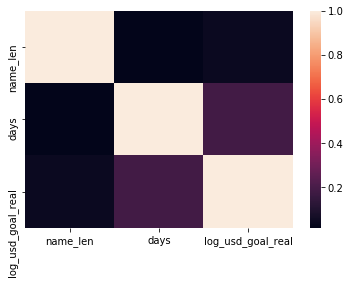

In [251]:
sns.heatmap(df_ks_data[["name_len","days","log_usd_goal_real"]].corr())

（考察）　相関係数は低いので、相関はなさそう。

## ハイパーパラメータ探索
SGDClassifier関数の中でパラメータが存在する。

| パラメータ | 内容 | 考察　| 
| --- | --- | --- | 
| loss | logでロジスティック回帰, hingeで　リニアSVM | アルゴリズムまで変えてしまうと別になるので変更しない |
| penalty | l2,l1,elasticnet で正則化を選択、noneでなし | ハイパーパラメータとして使用してみる |
| max_iter | エポック数の指定 | ハイパーパラメータと使用してみる |
| fit_intercept | 切片 | ハイパーパラメータとして使用してみる |
| random_state |　乱数のシード | シードを変えてしまうと比較しにくいので変えない |
| tol | エポックに対する停止基準 | 停止基準なので、変えない |


上記からpenalty,max_iter, fit_iterceptでグリッドサーチを行ってみる。

In [252]:
parameters = { \
              'penalty':['none', 'l2','l1','elasticnet'], \
              'max_iter':[5000, 10000,50000], \
              'fit_intercept':[True, False] \
              #'loss':['log'], \
              #'random_state':[1234], \
             #'tol':[1e-3] \
             }

In [253]:
# 対象データのうち1/5をテストデータとする。
y = df_ks_data["state_bool"].values
X = df_ks_data.drop('state_bool', axis=1)

test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train_hold, X_test_hold, y_train_hold, y_test_hold = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

In [254]:
# 量的変数を標準化し,データを作成する。
stdsc_days = StandardScaler()
stdsc_log_usd_goal_real = StandardScaler()
stdsc_name_len = StandardScaler()

# 期間の標準化を追加
X_train_hold= trans_stdsc(X_train_hold,"days","days_stdsc",stdsc_days,True)


# ドル換算の目標金額のlog換算の標準化を追加
X_train_hold = trans_stdsc(X_train_hold,"log_usd_goal_real","log_usd_goal_real_stdsc",stdsc_log_usd_goal_real,True)

# プロジェクト名の文字数の標準化を追加
X_train_hold = trans_stdsc(X_train_hold,"name_len","name_len_stdsc",stdsc_name_len,True)

C:\Users\fumit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\fumit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\fumit\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\fumit\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [255]:
# モデル作成（グリッドサーチ）
def make_model_grid(X, y):
    model =  SGDClassifier(loss='log', random_state=1234, tol=1e-3)
    clf = GridSearchCV(model, parameters, cv=3,)
    clf.fit(X, y)
    return clf    


In [256]:
# グリッドサーチでモデルを作成
clf = make_model_grid(X_train_hold, y_train_hold)
print(clf.best_params_, clf.best_score_)

{'fit_intercept': False, 'max_iter': 5000, 'penalty': 'elasticnet'} 0.6752430843446144


（考察）　切片なし、エポック数 5000, 正則化 elasticnetがベストと判断された。

In [257]:
# 最適パラメータを用いて識別する
clf2 = SGDClassifier(**clf.best_params_, loss='log', random_state=1234, tol=1e-3)
clf2.fit(X_train_hold, y_train_hold)
print("識別精度=",clf2.score(X_test_hold, y_test_hold))

識別精度= 0.5988995251375594


In [258]:
# ホールドアウト法のテスト

# 期間の標準化を追加
X_test_hold= trans_stdsc(X_test_hold,"days","days_stdsc",stdsc_days,False)


# ドル換算の目標金額のlog換算の標準化を追加
X_test_hold = trans_stdsc(X_test_hold,"log_usd_goal_real","log_usd_goal_real_stdsc",stdsc_log_usd_goal_real,False)

# プロジェクト名の文字数の標準化を追加
X_test_hold = trans_stdsc(X_test_hold,"name_len","name_len_stdsc",stdsc_name_len,False)

run_model_and_print_result(X_test_hold, y_test_hold, clf2)


C:\Users\fumit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\fumit\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\fumit\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\fumit\Anaconda3\lib\site-p

対数尤度 = -11.229
正答率（Accuracy） = 67.489%
適合率（Precision） = 61.540%
再現率（Recall） = 50.517%
F1値（F1-score） = 55.486%
         予測 = 失敗  予測 = 成功
正解 = 失敗    31328     8400
正解 = 成功    13166    13441


（考察）　これをみる限り、劇的に改善されたとは考えにくいが、ロジスティック回帰の限界？